In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import librosa.display
import librosa
import pickle

In [2]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.0


In [3]:
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 128
sr = 48000
fx = ["Clean", "TubeScreamer", "BluesDriver", "RAT", "Chorus", "Phaser", "Flanger", "Tape Echo","Sweep Echo", "Digital Delay", "Hall Reverb", "PlateReverb", "Spring Reverb"]


In [16]:
with open('/Users/mezaga93/Desktop/sintesis_aciml.pkl', 'rb') as f:
  waveforms = pickle.load(f)
print(waveforms.shape)

(5000, 64000)


In [17]:
waveforms = waveforms[0:5000:10,:16000]
#waveforms = [i for i in range(0,len(waveforms),10)]
print(waveforms.shape)

(500, 16000)


In [18]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms- mu_wave)#/max_wave
## para evitar la division entre ceros
Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
print(Xw.shape)

(500, 16000)


In [19]:
#####reshape de los datos
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(500, 16000, 1, 1)


In [20]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))

In [30]:
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.00001)

In [23]:
latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
vae_encoder.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-15 18:59:01.017075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 18:59:01.017955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 4000, 1, 64)  4288        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1000, 1, 128  540800      ['conv2d[0][0]']                 
                                )                                                                 
                                                                                        

In [24]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
vae_decoder.summary()

Model: "decoder_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 64000)             8256000   
                                                                 
 reshape (Reshape)           (None, 250, 1, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1000, 1, 128)     2162816   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4000, 1, 64)      540736    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16000, 1, 1)      

In [25]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

In [31]:
tr_logs = vae.fit(Xw[:800],Xw[:800], shuffle = True, batch_size= 5, epochs= 80)


Epoch 1/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0860
Epoch 2/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0866
Epoch 3/80
100/100 [==============================] - 8s 76ms/step - loss: 0.0877
Epoch 4/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0858
Epoch 5/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0831
Epoch 6/80
100/100 [==============================] - 8s 76ms/step - loss: 0.0825
Epoch 7/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0815
Epoch 8/80
100/100 [==============================] - 8s 76ms/step - loss: 0.0802
Epoch 9/80
100/100 [==============================] - 8s 76ms/step - loss: 0.0789
Epoch 10/80
100/100 [==============================] - 8s 76ms/step - loss: 0.0778
Epoch 11/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0770
Epoch 12/80
100/100 [==============================] - 8s 75ms/step - loss: 0.0769
Epoch 13/80
1

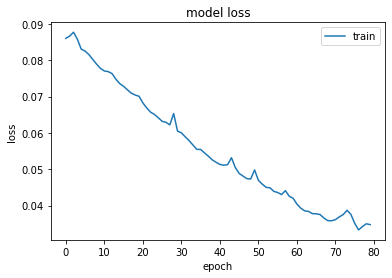

In [32]:
#plt.plot(loss)
plt.plot(tr_logs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [33]:
y_hat = vae.predict(Xw)

 1/16 [>.............................] - ETA: 3s

2022-06-15 19:22:07.974287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 4s 223ms/step


In [34]:
y_hat.shape

(500, 16000, 1, 1)

[0, 100, 200, 300, 400]


/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_2061/1593705874.py:7: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y_hat[x].flatten(),16000,color='r')


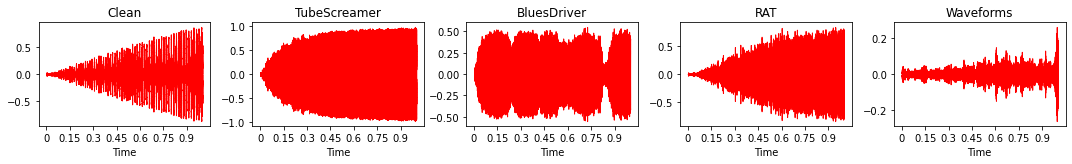

In [36]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(0,500,100)]
print(sonidos)
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(y_hat[x].flatten(),16000,color='r')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_2061/4238528815.py:5: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(Xw[x].flatten(),16000, color='b')


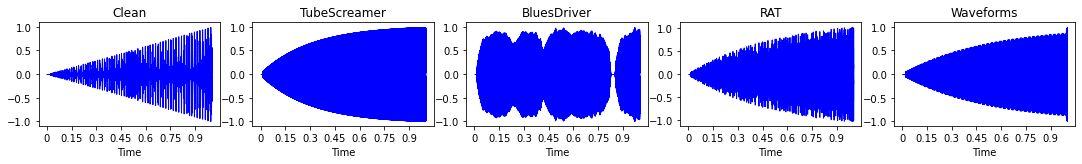

In [38]:
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(0,500,100)]
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(Xw[x].flatten(),16000, color='b')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

In [41]:
latent = vae_encoder.predict(Xw)


2022-06-15 19:42:58.719700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 76ms/step


variance: 
[0.08826623 0.07570197 0.06175343]


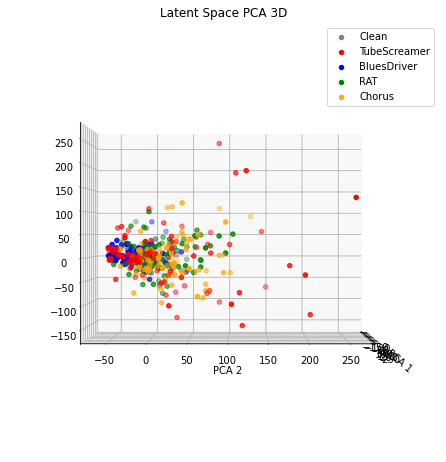

In [44]:
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig,elev=-0, azim=0.4,auto_add_to_figure=False)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 3)

X_PCA = pca.fit_transform(latent[0])
print('variance: ')
print(pca.explained_variance_ratio_)
ax.scatter3D(X_PCA[:99, 0], X_PCA[:99, 1],X_PCA[:99, 2], c='gray', label= fx[0])
ax.scatter3D(X_PCA[100:199, 0], X_PCA[100:199, 1],X_PCA[100:199, 2], c='red', label= fx[1])
ax.scatter3D(X_PCA[200:299, 0], X_PCA[200:299, 1],X_PCA[200:299, 2], c='blue', label= fx[2])
ax.scatter3D(X_PCA[300:399, 0], X_PCA[300:399, 1],X_PCA[300:399, 2], c='green', label= fx[3])
ax.scatter3D(X_PCA[400:499, 0], X_PCA[400:499, 1],X_PCA[400:499, 2], c='orange', label= fx[4])

fig.add_axes(ax)
plt.legend()
plt.title('Latent Space PCA 3D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.zlabel('PCA 3')

plt.show()

In [45]:
def latent_inter(audio_a, audio_b, step = 1):
  'step hace referencia al numero de audios entre las referencias'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step + 2).flatten()
  else:
    listas = np.linspace(audio_a, audio_b, step + 2)
  return listas

In [90]:
num = 2
num2 =  4
primero = sonidos[num]
print(primero)
segundo = sonidos[num2]
print(segundo)

gen_audio = 2
gen_latent = latent_inter(latent[0][primero],latent[0][segundo],gen_audio)
print(gen_latent.shape)

200
400
(4, 128)


1/1 [==============================] - 0s 10ms/step


/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_2061/972027539.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(v[i],16000, color='green')


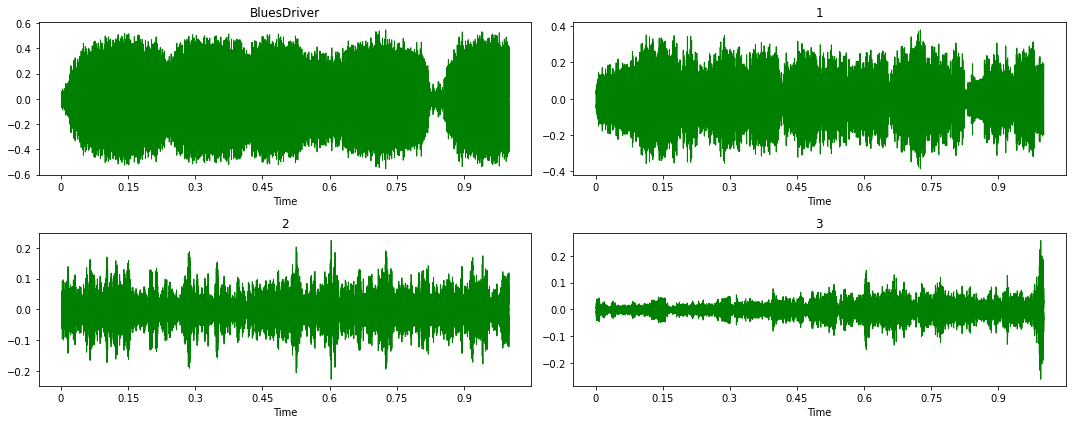

In [92]:
labels =[]
gen_latent = vae_decoder.predict(latent_inter(latent[0][primero],latent[0][segundo],gen_audio))
labels.extend([fx[num],1,2,3,4,5,6,7,8,9,10,fx[num2]])
v = [gen_latent[i].flatten() for i in range(gen_audio+2)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio+2):
    plt.subplot(2, 2, i+ 1).set_title(labels[i])
    librosa.display.waveshow(v[i],16000, color='green')
plt.tight_layout()
#plt.title()
plt.show()

In [76]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [89]:
Audio(v[6], 16000)
